In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [11]:
sys.path.append("..")
from model.uplift_model import *
from model.roi_model import *

In [12]:
import matplotlib.pyplot as plt

def plot_loss(history, *losses):
    for loss in losses:
        plt.plot(history.history[loss], label=loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [13]:
import causalml
from causalml.metrics import *
import matplotlib.pyplot as plt


def get_causalml_auuc(Y, T, ite_pred, normalize=True):

    metric_df = pd.DataFrame([ite_pred.flatten(),
                               Y.flatten(),
                               T.flatten()]).T


    metric_df.columns=['model','y','w'] 
    uplift_rank_lift = get_cumlift(metric_df)

    normalize = True

    uplift_rank_gain = uplift_rank_lift.mul(uplift_rank_lift.index.values, axis=0)
    if normalize:
        uplift_rank_gain = uplift_rank_gain.div(np.abs(uplift_rank_gain.iloc[-1, :]), axis=1)
    uplift_rank_auuc_score = uplift_rank_gain.sum()/uplift_rank_gain.shape[0]
    
    print(uplift_rank_auuc_score)
    
    step = len(T) // 200 
    
    uplift_rank_gain.iloc[::step, :].plot()
    plt.show()
    
    return uplift_rank_auuc_score, uplift_rank_gain.iloc[::step, :]

In [19]:
count = 20

trainable_weights
p1_hidden_1/kernel:0
p1_hidden_1/bias:0
p1/kernel:0
p1/bias:0
non_trainable_weights
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p0_raw_features (InputLayer)    [(None, 76)]         0                                            
__________________________________________________________________________________________________
p1_hidden_1 (Dense)             (None, 64)           4928        p0_raw_features[0][0]            
__________________________________________________________________________________________________
treated_input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
reward_input (InputLayer)       [(None, 1)]          0                                   

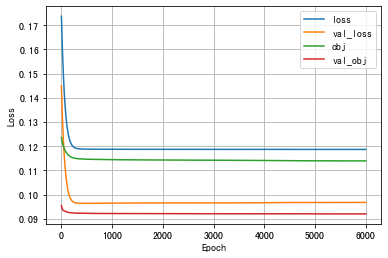

iteration =  3


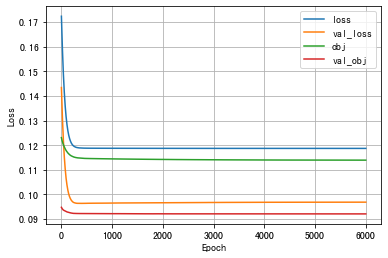

iteration =  4


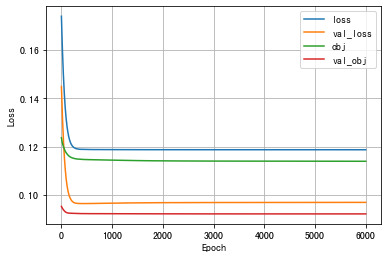

iteration =  5


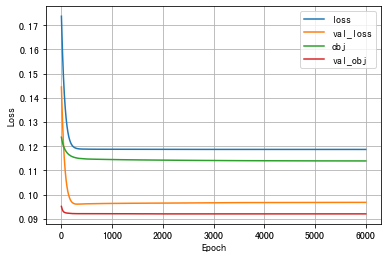

iteration =  6


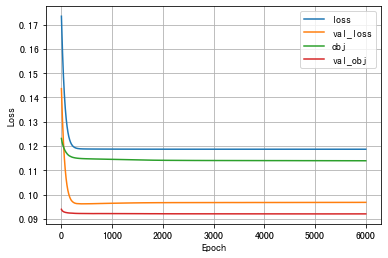

iteration =  7


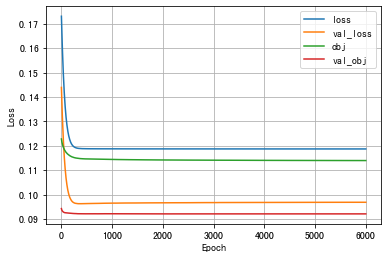

iteration =  8


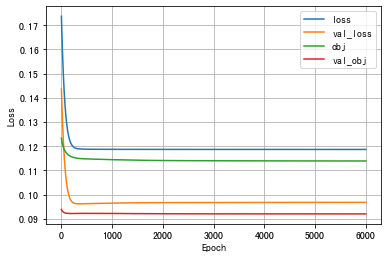

iteration =  9


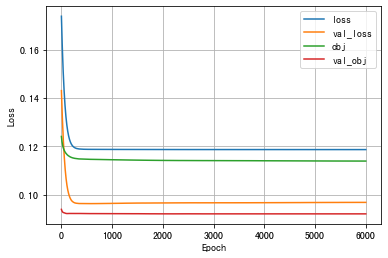

iteration =  10


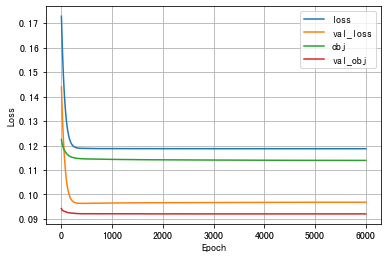

iteration =  11


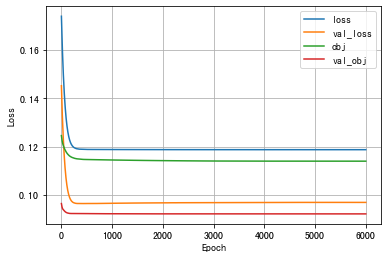

iteration =  12


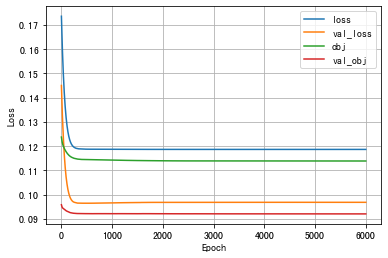

iteration =  13


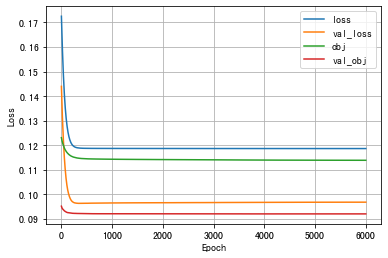

iteration =  14


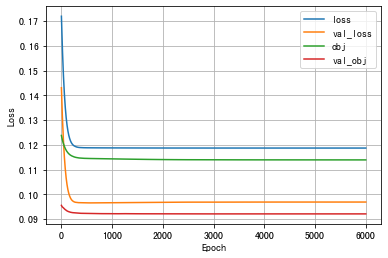

iteration =  15


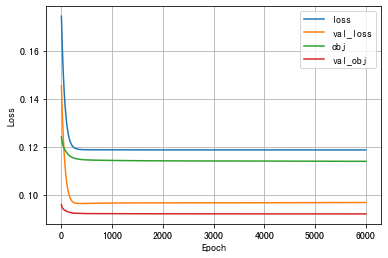

iteration =  16


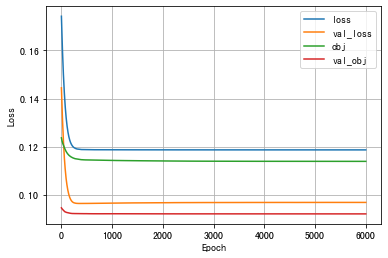

iteration =  17


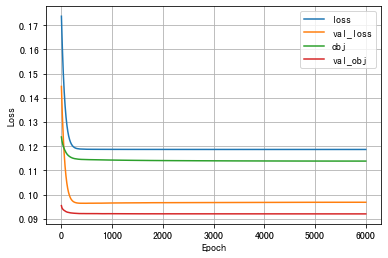

iteration =  18


KeyboardInterrupt: 

In [20]:
# UPLIFT RANK MODEL
# 7e-4
import keras
import keras.backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from model.uplift_model import *

final_model = get_uplift_rank_model()
final_model.compile(loss=None, optimizer='adam')
#lambda y_true,y_pred: y_pred
print('trainable_weights')
for x in final_model.trainable_weights:
    print(x.name)
print('non_trainable_weights')
for x in final_model.non_trainable_weights:
    print(x.name)
final_model.summary()

for i in range(1, count):

    print("iteration = ", i + 1)
    
    final_model = get_uplift_rank_model()
    final_model.compile(loss=None, optimizer='adam')

    mcp_save = ModelCheckpoint('../model_file/uplift/marketing/final_model/upliftRank/uplift_rank_marketing_model_{}.h5'.format(i+1), save_best_only=False, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit([X, T, Yr], validation_split=0.2, epochs=6000, batch_size=4096000, shuffle=True, verbose=0, callbacks=[mcp_save])

    
    plot_loss(history, "loss", "val_loss", "obj", "val_obj")
